In [ ]:
!pip install transformers;

In [72]:
import pandas as pd
import random
import numpy as np
from tqdm import tqdm

import os

import time
import datetime

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

import torch

from torch.utils.data import TensorDataset, random_split

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt

import seaborn as sns

General Setup

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [92]:
data = pd.read_csv("/content/drive/MyDrive/Google Colab - ALab/Data/20221120-122950_CMACGM_DataFrame_Clean.csv")
data.head()

,index,CaseNumber,Type,Topics,TeamName,RequesterEmail,EmailObject,LastEmailCCAddress,AttributesURL,ContactAttributesURL,ContactEmail,LastIncomingEmailContent,LastEmailCCAddressCount,CMA_in_cc,CountMailsInConversation,LastEmailContent
0,2,102008670,0,NaN,US-NOR-CMA-BKG-EXP-COTTON,meri.austin.oxner@staplcotn.com,NAM5095295 and NAM5156664 and,NaN,5005p00002ewEhvAAE,0035p00003jMYYXAA4,meri.austin.oxner@staplcotn.com,"\nHello, \n \nPlease send updated booking conf...",0,False,1,hello please send updated booking confirmation...
1,5,102023112,0,T037,US-NOR-CMA-BKG-ELITE-BASF,karin.goebel@bdpint.com,BASF past cutoff - pending upd,NaN,5005p00002g1ixvAAA,0030N00002z86qTQAQ,karin.goebel@bdpint.com,"P {margin-top:0;margin-bottom:0;} CMA CGM, bel...",0,False,1,p
2,6,101523802,0,T018,US-NOR-CMA-BKG-PREFERRED,NaN,"BOOKING REQUEST, WEB, CARR=CMA",NaN,5005p00002ew3TWAAY,0030N00002qC29RQAS,jbecerril@bashipping.com,"\nWhat is the schedule\n \nBest Regards, \n \n...",0,False,5,what is the schedule best regards jose becerri...
3,7,100555933,0,T847,US-NOR-CMA-BKG-STARS,NaN,"BOOKING REQUEST, WEB, CARR=CMA",NaN,5005p00002g0hgTAAQ,0030N00003RcxNWQAZ,jessical@ecuworldwide.com,\n,0,False,1,NaN
4,8,100067077,0,T031,US-NOR-CMA-BKG-PMR-EVONIK,jose.barahona@bdpint.com,"BOOKING REQUEST, EDI=CARGOSMAR",usa.cmaexportactive@usa.cma-cgm.com; usa.arist...,5005p00002gTsGdAAK,0030N00002wY2gIQAS,jose.barahona@bdpint.com,\n,3,True,1,NaN


In [93]:
def make_str(word):
    if not isinstance(word, str):
        return ""
    return str(word)

def introduce_empty(word):
    if not word or not isinstance(word, str) or len(word) == 0:
        return "[EMPTY]"
    return word

def clean_up_pipeline(sentence):
    cleaning_utils = [make_str,
                      #remove_hyperlink,
                      #replace_newline,
                      #to_lower,
                      #remove_number,
                      #remove_punctuation,
                      #remove_whitespace,
                      introduce_empty]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

In [94]:
data["LastEmailContent"] = data["LastEmailContent"].apply(lambda x: clean_up_pipeline(x))

In [95]:
lengths = data["LastEmailContent"].str.len()
print(lengths.max())
argmax = np.where(lengths == lengths.max())[0]
print(data.iloc[argmax]["LastEmailContent"][83977])

2574


KeyError: ignored

In [96]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=1)

In [78]:
emails = train_data["LastEmailContent"].values
labels = train_data["Type"].values

Tokenization

In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for email in tqdm(emails):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        email,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        truncation=True,
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

  0%|          | 0/226110 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 226110/226110 [07:16<00:00, 517.79it/s]


In [ ]:
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', emails[0])
print('Token IDs:', input_ids[0])

Original:  [EMPTY]
Token IDs: tensor([ 101, 1031, 4064, 1033,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])


Train validation split

In [ ]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(len(train_dataset)))
print('{:>5,} validation samples'.format(len(val_dataset)))

203,499 training samples
22,611 validation samples


In [ ]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

Training the model

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Optimizer

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Metrics

In [ ]:
# Function to calculate the precision and recall of our predictions vs labels
def flat_precision_recall(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    precision, recall, _, _ = precision_recall_fscore_support(labels_flat, pred_flat, pos_label=1)
    return precision, recall

Training loop

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = output.loss
        logits = output.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_precision = 0
    total_eval_recall = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.        
            output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = output.loss
            logits = output.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        precision, recall = flat_precision_recall(logits, label_ids)
        total_eval_precision += precision[1]
        total_eval_recall += recall[1]
        

    # Report the final accuracy for this validation run.
    avg_val_precision = total_eval_precision / len(validation_dataloader)
    avg_val_recall = total_eval_recall / len(validation_dataloader)
    print("  Precision: {0:.2f}".format(avg_val_precision))
    print("  Recall: {0:.2f}".format(avg_val_recall))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Precision': avg_val_precision,
            'Valid. Recall': avg_val_recall,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

    output_dir = '/content/drive/MyDrive/Google Colab - ALab/NLP Models/model_save/epoch_' + str(epoch_i)

    # Create output directory if needed
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print("Saving model to %s" % output_dir)

    # Save a trained model, configuration and tokenizer using `save_pretrained()`.
    # They can then be reloaded using `from_pretrained()`
    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
    model_to_save.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 5 / 8 ========
Training...
  Batch    40  of  6,360.    Elapsed: 0:00:07.
  Batch    80  of  6,360.    Elapsed: 0:00:14.
  Batch   120  of  6,360.    Elapsed: 0:00:21.
  Batch   160  of  6,360.    Elapsed: 0:00:28.
  Batch   200  of  6,360.    Elapsed: 0:00:35.
  Batch   240  of  6,360.    Elapsed: 0:00:42.
  Batch   280  of  6,360.    Elapsed: 0:00:50.
  Batch   320  of  6,360.    Elapsed: 0:00:57.
  Batch   360  of  6,360.    Elapsed: 0:01:04.
  Batch   400  of  6,360.    Elapsed: 0:01:11.
  Batch   440  of  6,360.    Elapsed: 0:01:18.
  Batch   480  of  6,360.    Elapsed: 0:01:25.
  Batch   520  of  6,360.    Elapsed: 0:01:32.
  Batch   560  of  6,360.    Elapsed: 0:01:39.
  Batch   600  of  6,360.    Elapsed: 0:01:46.
  Batch   640  of  6,360.    Elapsed: 0:01:53.
  Batch   680  of  6,360.    Elapsed: 0:02:00.
  Batch   720  of  6,360.    Elapsed: 0:02:07.
  Batch   760  of  6,360.    Elapsed: 0:02:14.
  Batch   800  of  6,360.    Elapsed: 0:02:21.
  Batch   840  of

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)
 
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Precision,Valid. Recall,Training Time,Validation Time
epoch,,,,,,
1,0.48,0.44,0.69,0.48,0:18:46,0:00:36
2,0.42,0.43,0.67,0.65,0:18:43,0:00:36
3,0.37,0.47,0.71,0.54,0:18:42,0:00:36
4,0.32,0.49,0.68,0.62,0:18:42,0:00:36


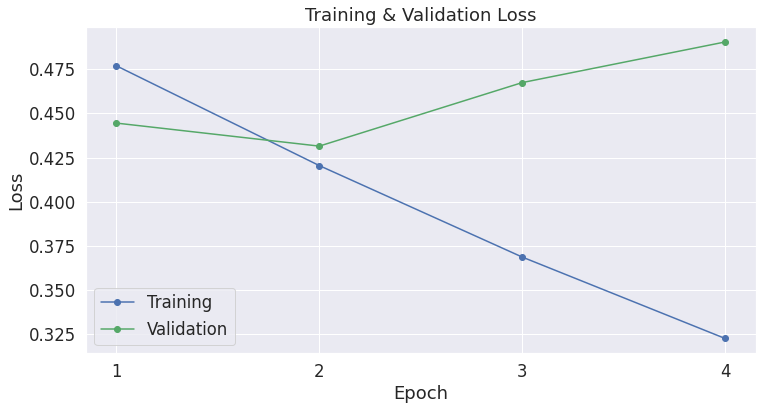

In [ ]:
%matplotlib inline

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

Predict on test set

In [97]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test_data.shape[0]))

# Create sentence and label lists
emails = data["LastEmailContent"].values
labels = data["Type"].values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for email in tqdm(emails):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        email,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        truncation=True,
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 29



  0%|          | 0/283 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).

100%|██████████| 283/283 [00:00<00:00, 517.00it/s]


In [55]:
embed = input_ids.detach().cpu().numpy()

In [56]:
import plotly.express as px
from sklearn.decomposition import PCA

X = pd.DataFrame(embed)

In [57]:
X["labels"] = labels.detach().cpu().numpy()

In [32]:
X = X.sample(n=100)

In [38]:
X_pca = X.drop("labels", axis=1)

pca = PCA(n_components=3)
components = pca.fit_transform(X_pca)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=X['labels'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [51]:
pca = PCA()
components = pca.fit_transform(X_pca)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(6),
    color=X["labels"]
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [34]:
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

In [46]:
X = X.sample(n=100)
X_pca = X.drop("labels", axis=1)

In [47]:
time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_pca)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 30588.218565
[t-SNE] KL divergence after 250 iterations with early exaggeration: 132.478989
[t-SNE] KL divergence after 300 iterations: 2.450434
t-SNE done! Time elapsed: 0.2833242416381836 seconds


In [48]:
fig = px.scatter_3d(
    tsne_results, x=0, y=1, z=2, color=X['labels'],
    labels={'0': '1', '1': '2', '2': '3'}
)
fig.show()

In [68]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X_pca = X.drop("labels", axis=1)

#Fit the LDA model
model = LinearDiscriminantAnalysis()
X_lda = model.fit_transform(X_pca, X["labels"])

In [113]:
ddd = pd.DataFrame([X_lda[:, 0], X["labels"]]).T

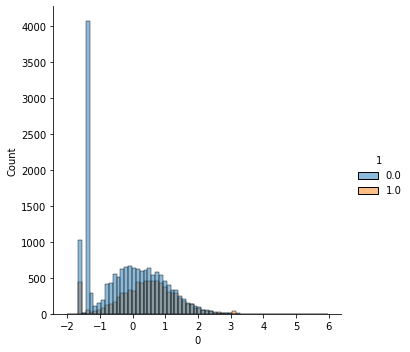

In [116]:
sns.displot(ddd, x=0, hue=ddd[1])

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels, probabilities = [], [], []

# Predict 
for batch in tqdm(prediction_dataloader):
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  probs = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  probabilities.append(probs)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 251,234 test sentences...


100%|██████████| 7852/7852 [06:47<00:00, 19.27it/s]

    DONE.


In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
precision, recall, _, _ = precision_recall_fscore_support(flat_true_labels, flat_predictions, pos_label=1)

print('Total Precision: %.3f' % precision[1])
print('Total Recall: %.3f' % recall[1])

Total Precision: 0.835
Total Recall: 0.670


In [ ]:
flat_probabilities = np.concatenate(probabilities, axis=0)[:, 1]

In [ ]:
save_data = pd.DataFrame(flat_probabilities, index=data["CaseNumber"], columns=["NN_probs"])

In [ ]:
save_data

,NN_probs
CaseNumber,
100124562,0.050951
100080371,0.058730
100095395,0.058365
100097054,0.006992
100097055,0.006992
...,...
102470077,0.804205
102510003,0.462946
102509997,0.615072


In [ ]:
save_data.to_csv(output_dir + "/NN_probabilities_Full.csv")

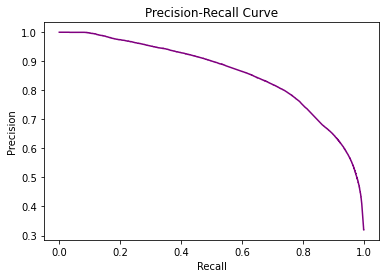

In [ ]:
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(flat_true_labels, flat_probabilities)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

----------------------------------------------------------------

In [79]:
output_dir = '/content/drive/MyDrive/Google Colab - ALab/NLP Models/BERT_final/epoch_1'

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
#torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Loading the model

In [80]:
# Load a trained model and vocabulary that you have fine-tuned
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
# Tell pytorch to run this model on the GPU.
model.cuda()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device);